In [1]:
from scipy.io import netcdf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import netCDF4
from mpl_toolkits.basemap import Basemap
import pandas as pd
import pygem
import astropy

import os
import matplotlib.pyplot as plt

import xarray as xr
import numpy as np
import pandas as pd
import netCDF4

import oggm
from oggm import cfg, utils, workflow, tasks, graphics, global_tasks, DEFAULT_BASE_URL
from oggm.core import massbalance, flowline
from oggm.sandbox import distribute_2d

from oggm.tasks import process_w5e5_data
from oggm.tasks import process_cru_data
from oggm.tasks import process_histalp_data
from oggm.tasks import process_ecmwf_data
from oggm.shop.ecmwf import get_ecmwf_file

from sklearn.preprocessing import MinMaxScaler

In [2]:
fp='hourly_precip.nc'
nc = netCDF4.Dataset(fp)

In [ ]:
for dim in nc.dimensions.values():
    print(dim)

In [ ]:
nc.dimensions

In [ ]:
nc.variables

In [ ]:
lat = nc.variables['latitude'][:]
print(lat)

In [ ]:
lon = nc.variables['longitude'][:]
print(lon)

In [ ]:
time = nc.variables['time'][:]
print(time)

In [ ]:
precip = nc.variables['tp'][:,0,0]#49,16
print(precip)

In [ ]:
len(precip)

### OGGM to get climate data - is ERA5 monthly. Much easier this way. 

In [ ]:
cfg.initialize(logging_level='WARNING')
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-ref-mb', reset=True)
cfg.PARAMS['border'] = 80
cfg.PARAMS['store_model_geometry'] = True

cfg.PARAMS['use_multiprocessing'] = True

rgi11 = []
region = '11'
for i in range(1,1800):
    strbase = 'RGI60-'+region+'.'
    strbase = strbase +(str(i).zfill(5))
    rgi11.append(strbase)
    
gdirs = workflow.init_glacier_directories(rgi11, from_prepro_level=4,
                                              prepro_base_url=DEFAULT_BASE_URL)

In [ ]:
gdir = gdirs[3]
gdir.rgi_id

In [ ]:
gdir = gdirs[3]
climate = tasks.process_ecmwf_data(gdir,dataset = 'ERA5',y0=2000)

bpath = cfg.PATHS['working_dir']
climate = netCDF4.Dataset(bpath+ '/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00004/climate_historical.nc')

tmp_vec = list(climate.variables['temp'][:])#2000 beyond
prcp_vec = list(climate.variables['prcp'][:])

In [ ]:
climate.variables

In [ ]:
#climate.variables['time'][:]
len(tmp_vec)

In [ ]:
gdir.rgi_id

In [ ]:
len(prcp_vec)

In [ ]:
prcp_vec

## Rounce test

### monthly run

#### Use this to get modeled data from Pygem

In [ ]:
nc_glac = 'R11_glac_mass_annual_50sets_2000_2100-rcp85.nc'
nc_glac = netCDF4.Dataset(nc_glac)

In [ ]:
for dim in nc_glac.dimensions.values():
    print(dim)

In [ ]:
nc_glac['glac_mass_annual']

In [ ]:
nc_glac.variables.keys()

In [ ]:
yrs = nc_glac['year'][:]
yrs

In [ ]:
yr_mth = []
for yr in yrs:
    str_year = str(yr)
    for i in range(1,13):
        month = str(i)
        strval = str_year + '-' + month
        yr_mth.append(strval)

In [ ]:
yr_mth = yr_mth[0:240]

In [ ]:
glac_mb = nc_glac['glac_mass_annual'][1,500,:][0:20]
list_mb = []

for val in glac_mb:
    mb_vals = [val]*12
    list_mb.append(mb_vals)

In [ ]:
def flatten(xss):
    return [x for xs in xss for x in xs]
list_mb = flatten(list_mb)

In [ ]:
list_mb

In [ ]:
offset = netCDF4.Dataset('regional_offset.nc')

acc = (offset.variables['reg_melt_monthly'][11,0,0,:][0:240])
acc_f = []

for val in melt:
    acc = acc/3925#change - magic number
    acc_f.append(acc)
    
melt = (offset.variables['reg_acc_monthly'][11,0,0,:][0:240])
melt_f = []

for val in melt:
    melt = melt/3925#change - magic number
    melt_f.append(melt)    

In [ ]:
melt_f[0]

# Regional offset to get monthly melt and accum.

In [ ]:
offset = netCDF4.Dataset('regional_offset.nc')
#offset.variables

In [ ]:
melt = (offset.variables['reg_acc_monthly'][11,0,0,:][0:240])
melt_f = []

for val in melt:
    melt = melt/3925#change - magic number
    melt_f.append(melt)

In [ ]:
acc = (offset.variables['reg_melt_monthly'][11,0,0,:][0:240])
acc_f = []

for val in melt:
    acc = acc/3925#change - magic number
    acc_f.append(acc)

In [ ]:
len(np.array(list_mb) - (melt_f[0]) + (acc_f[0]))

## Expand the same for all glaciers

In [ ]:
def flatten(xss):
    return [x for xs in xss for x in xs]
#list_mb = flatten(list_mb)

In [ ]:
nc_glac = 'R11_glac_mass_annual_50sets_2000_2100-rcp85.nc'
nc_glac = netCDF4.Dataset(nc_glac)

In [ ]:
offset = netCDF4.Dataset('regional_offset.nc')

acc = (offset.variables['reg_melt_monthly'][11,0,0,:][0:240])
acc_f = []

for val in melt:
    acc = acc/3925#change - magic number
    acc_f.append(acc)
    
melt = (offset.variables['reg_acc_monthly'][11,0,0,:][0:240])
melt_f = []

for val in melt:
    melt = melt/3925#change - magic number
    melt_f.append(melt)    

In [ ]:
#Step 1...get year dat a-yr-mth
yr_mth = []
for yr in yrs:
    str_year = str(yr)
    for i in range(1,13):
        month = str(i)
        strval = str_year + '-' + month
        yr_mth.append(strval)
yr_mth = yr_mth[0:240]

In [ ]:
#Step 2..the rest
rgi = []
balance = []
prec = []
temp = []
time = []

for i in range(0,1700):
    gdir = gdirs[i]
    climate = tasks.process_ecmwf_data(gdir,dataset = 'ERA5',y0=2000,)

    bpath = cfg.PATHS['working_dir']
    
    if i<999:
        dir_val = str(i+1).zfill(3)
        climate = netCDF4.Dataset(bpath+ '/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00'+dir_val+'/climate_historical.nc')
    elif i < 1999 and i >= 999:
        dir_val = str(i+1).zfill(5)
        climate = netCDF4.Dataset(bpath+ '/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.'+dir_val+'/climate_historical.nc')

    #climate variables
    tmp_vec = list(climate.variables['temp'][:])#year 2000 beyond
    prcp_vec = list(climate.variables['prcp'][:])
    
    rgival = [gdir.rgi_id]*240
    
    #mass balance values
    glac_mb = nc_glac['glac_mass_annual'][1,i+1,:][0:20]
    list_mb = []

    #convert to monthly
    for val in glac_mb:
        mb_vals = [val]*12
        list_mb.append(mb_vals)
    
    #offset w/ regional acc/melt
    list_mb = flatten(list_mb)
    list_mb = np.array(list_mb) - (melt_f[0]) + np.array(acc_f[0])
    list_mb = list_mb.tolist()
    
    
    prec.append(prcp_vec)
    temp.append(tmp_vec)
    rgi.append(rgival)
    balance.append(list_mb)
    time.append(yr_mth)
    

In [ ]:
prec_f = flatten(prec)
temp_f = flatten(temp)
rgi_f = flatten(rgi)
balance_f = flatten(balance)
time_f = flatten(time)

In [ ]:
df_fin = pd.DataFrame([rgi_f,time_f,prec_f,temp_f,balance_f]).transpose()
df_fin.head()

In [ ]:
df_fin.tail()

In [ ]:
df_fin.columns = ['RGI_ID','date','prcp','tmp','balance']

In [ ]:
df_fin.to_csv('full_data_monthlymodel.csv')

### Run the model 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense, Dropout, Bidirectional, RNN
from sklearn.model_selection import train_test_split
import math
from tensorflow.keras.utils import plot_model
import pydot
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

In [ ]:
df_fin = pd.read_csv('full_data_monthlymodel.csv')

scaler = MinMaxScaler()
df_X = df_fin[['prcp','tmp']]
df_X = scaler.fit_transform(df_X)

df_y = df_fin[['balance']]
df_y = scaler.fit_transform(df_y)

In [ ]:
df_X.shape

In [ ]:
#df_X = df_X.to_numpy()
df_X = df_X.reshape(1700,240,2)#magic number...change

#df_y = df_y.to_numpy()
df_y = df_y.reshape(1700,240)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2,random_state = 123)
X_train.shape

In [ ]:
X_train_partial = X_train[0:1050]
y_train_partial = y_train[0:1050]
X_train_val = X_train[1050:]
y_train_val = y_train[1050:]

In [ ]:
model = tf.keras.Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True,input_shape=(240, 2), activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=32, return_sequences=True,activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=32,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=16,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=8,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=4,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dense(1))

my_adam_optimizer = Adam(learning_rate=1e-7)
model.compile(optimizer=my_adam_optimizer, loss='mse')

In [ ]:
history = model.fit(X_train_partial, y_train_partial,validation_data=(X_train_val,y_train_val),epochs =100)

In [ ]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Bidirectional LSTM Loss')
plt.show();

In [ ]:
trainScore = model.evaluate(X_train_partial, y_train_partial, verbose=2)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_train_val, y_train_val, verbose=2)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

In [ ]:
# make predictions
trainPredict = model.predict(X_train_partial)
testPredict = model.predict(X_train_val)
# invert predictions-guessing i have to loop thru this for 3d?
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1,1)).reshape(trainPredict.shape)
testPredict = scaler.inverse_transform(testPredict.reshape(-1,1)).reshape(testPredict.shape).squeeze()

testY = scaler.inverse_transform(y_train_val)

In [ ]:
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

### model 2

In [ ]:
model = tf.keras.Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True,input_shape=(240, 2), activation = 'tanh',recurrent_dropout=0.1)))
#model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(64,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
#model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=32, return_sequences=True,activation = 'tanh',recurrent_dropout=0.1)))
#model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=32,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
#model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=16,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dense(1))

my_adam_optimizer = Adam(learning_rate=1e-7)
model.compile(optimizer=my_adam_optimizer, loss='mse')

In [ ]:
history = model.fit(X_train_partial, y_train_partial,validation_data=(X_train_val,y_train_val),epochs =100)

In [ ]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Bidirectional LSTM Loss')
plt.show();

# model 3 - larger with more layers

In [ ]:
model = tf.keras.Sequential()
model.add(Bidirectional(LSTM(256,return_sequences=True,input_shape=(240, 2), activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(128,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(64,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=32, return_sequences=True,activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=32,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=16,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
model.add(Bidirectional(LSTM(units=8,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dense(1))

my_adam_optimizer = Adam(learning_rate=5e-8)
model.compile(optimizer=my_adam_optimizer, loss='mse')

In [ ]:
history = model.fit(X_train_partial, y_train_partial,validation_data=(X_train_val,y_train_val),epochs =100)

In [ ]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Bidirectional LSTM Loss')
plt.show();

### yearly run

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense, Dropout, Bidirectional, RNN
from sklearn.model_selection import train_test_split
import math
from tensorflow.keras.utils import plot_model,set_random_seed
import pydot
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

In [ ]:
def flatten(xss):
    return [x for xs in xss for x in xs]
#list_mb = flatten(list_mb)

In [ ]:
'''
jan_temp = []
jan_prcp = []
jul_temp = []
jul_prcp = []

df_fin = []

for i in range(1,1700):
    try:
        gdir = gdirs[i]

        climate = tasks.process_ecmwf_data(gdir,dataset = 'ERA5',y0=1979, y1 = 2020)

        bpath = cfg.PATHS['working_dir']
        
        #rewrite
        if i<1000:
            dir_val = str(i+1).zfill(3)
            climate = netCDF4.Dataset(bpath+ '/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00'+dir_val+'/climate_historical.nc')
        elif i < 2000 and i >= 1000:
            dir_val = str(i+1).zfill(5)
            climate = netCDF4.Dataset(bpath+ '/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.'+dir_val+'/climate_historical.nc')
        elif i >=2000 and i<3000:
            dir_val = str(i+1).zfill(5)
            climate = netCDF4.Dataset(bpath+ '/per_glacier/RGI60-11/RGI60-11.02/RGI60-11.'+dir_val+'/climate_historical.nc')
        elif i>=3000 and i<4000:
            dir_val = str(i+1).zfill(5)
            climate = netCDF4.Dataset(bpath+ '/per_glacier/RGI60-11/RGI60-11.03/RGI60-11.'+dir_val+'/climate_historical.nc')
        else:
            pass
            
        tmp_vec = list(climate.variables['temp'][:])
        prcp_vec = list(climate.variables['prcp'][:])
        years = list(np.arange(1979, 2020))

        for j in range(0,len(tmp_vec)):
            if j%12 == 0:
                jan_temp.append(tmp_vec[j])
                jan_prcp.append(prcp_vec[j])

            elif (j%12)==6:
                jul_temp.append(tmp_vec[j])
                jul_prcp.append(prcp_vec[j])
            else:
                pass

        df_1 = pd.DataFrame([jan_temp,jul_temp,jan_prcp,jul_prcp,years]).transpose()
        df_1.columns = ['jan_temp','jul_temp','jan_prcp','jul_prcp','years']
        df_1['RGI_ID'] = gdir.rgi_id
        df_fin.append(df_1)

        #df_1.to_csv(os.getcwd()+'/Climate/RGI60-11.00'+dir_val+'.csv')
    except:
        print(gdir.rgi_id)
'''
    

In [ ]:
nc_glac = 'R11_glac_mass_annual_50sets_2000_2100-rcp85.nc'
nc_glac = netCDF4.Dataset(nc_glac)

In [ ]:
df_mb = pd.read_csv('alps_full_climate_1700glac.csv')
df_mb.head()

In [ ]:
df_mb = df_mb[df_mb['years'].notna()]
df_mb['years'] = df_mb['years'].astype(int)

In [ ]:
mbs = []
rgis = []
yrs = []

for i in range(0,1700):
    gdir = gdirs[i]
    glac_mb = nc_glac['glac_mass_annual'][1,i,:][0:20]
    rgival = [gdir.rgi_id]*20
    yr = [i for i in range(2000,2020)]
    
    
    mbs.append(glac_mb)
    rgis.append(rgival)
    yrs.append(yr)

In [ ]:
mass_f = flatten(mbs)
rgis_f = flatten(rgis)
yrs = flatten(yrs)

In [ ]:
df_mass = pd.DataFrame([mass_f,rgis_f,yrs]).transpose()
df_mass.columns = ['mass','RGI_ID','years']
df_mass.head()

In [ ]:
df_fin = df_mass.merge(df_mb, how = 'left', on = ['RGI_ID','years'])

In [ ]:
df_fin.tail()

In [ ]:
df_fin = df_fin[df_fin['jan_temp'].notna()]

In [ ]:
df_fin.to_csv('yearlyfull.csv', index = False)

### model w/ just climate

In [3]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import LSTM,Dense, Dropout, Bidirectional, RNN
from sklearn.model_selection import train_test_split
import math
from tensorflow.keras.utils import plot_model
import pydot
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

In [4]:
from numpy.random import seed
import random as python_random


def reset_seeds():
    seed(417)
    tf.random.set_seed(417)
    python_random.seed(417)

reset_seeds()
df_fin = pd.read_csv('yearlyfull.csv')

In [5]:
df_fin.drop(['jan_prcp'],axis=1,inplace=True)
df_fin.shape

(33960, 6)

In [6]:
df_fin.head()

,mass,RGI_ID,years,jan_temp,jul_temp,jul_prcp
0,9.114250e+10,RGI60-11.00002,2000,-7.131073,11.542938,236.637115
1,9.244161e+10,RGI60-11.00002,2001,-5.533630,13.946198,160.340286
2,9.038351e+10,RGI60-11.00002,2002,-5.909180,14.390503,196.515427
3,8.879609e+10,RGI60-11.00002,2003,-5.967377,14.402863,174.810440
4,8.986629e+10,RGI60-11.00002,2004,-6.445190,13.262054,192.130508


In [ ]:
scaler = MinMaxScaler()
df_X = df_fin[['jul_temp','jul_prcp']]
df_X = scaler.fit_transform(df_X)

df_y = df_fin[['mass']]
df_y = scaler.fit_transform(df_y)

In [ ]:
#df_X = df_X.to_numpy()
df_X = df_X.reshape(1698,20,2)#magic number...change

#df_y = df_y.to_numpy()
df_y = df_y.reshape(1698,20)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2,random_state = 123)
X_train_partial = X_train[0:1050]
y_train_partial = y_train[0:1050]
X_train_val = X_train[1050:]
y_train_val = y_train[1050:]

In [ ]:
model = tf.keras.Sequential()
model.add(Bidirectional(LSTM(16,input_shape = (20,2),return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=8, return_sequences=True,activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=4, return_sequences=True,activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=2,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Dense(1))

my_adam_optimizer = Adam(learning_rate=5e-6)
model.compile(optimizer=my_adam_optimizer, loss='mse', metrics = ['acc'])

In [ ]:
history = model.fit(X_train, y_train,validation_data=(X_test,y_test),epochs =100)

In [ ]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Bidirectional LSTM Loss')
plt.show();

In [ ]:
history = model.fit(X_train, y_train,validation_data=(X_test,y_test),epochs =50)

In [ ]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Bidirectional LSTM Loss')
plt.show();

### Adding in attributes

In [ ]:
from numpy.random import seed
import random as python_random


def reset_seeds():
    seed(417)
    tf.random.set_seed(417)
    python_random.seed(417)

In [ ]:
df_fin = pd.read_csv('yearlyfull.csv')
attr = pd.read_csv('11_attr6.csv')

In [ ]:
attr.columns

In [ ]:
attr = attr[['RGIId','Zmed','Slope','Aspect','Zmin','Zmax']]
attr.head()

In [ ]:
attr['HI'] = ((attr['Zmed'] -attr['Zmin'])/(attr['Zmax']-attr['Zmin']))

In [ ]:
attr = attr.rename(columns = {'RGIId':'RGI_ID'})

In [ ]:
attr.head()

In [ ]:
attr = attr[['RGI_ID','Zmed','Slope','Aspect','HI']]

In [ ]:
df_fin = attr.merge(df_fin, how = 'inner', on = ['RGI_ID'])

In [ ]:
df_fin = df_fin[['RGI_ID','years','mass','jan_temp','jan_prcp','jul_temp','jul_prcp','Slope',
                'Aspect','Zmed','HI']]
df_fin.tail()

In [ ]:
df_fin.to_csv('all_11.csv', index = False)

### Some EDA

### Base Neural Net Model

In [3]:
df_fin = pd.read_csv('all_11.csv')
df_fin.head()

,RGI_ID,years,mass,jan_temp,jan_prcp,jul_temp,jul_prcp,Slope,Aspect,Zmed,HI
0,RGI60-11.00002,2000,9.114250e+10,-7.131073,159.901688,11.542938,236.637115,18.6,49,2526,0.495399
1,RGI60-11.00002,2001,9.244161e+10,-5.533630,79.804756,13.946198,160.340286,18.6,49,2526,0.495399
2,RGI60-11.00002,2002,9.038351e+10,-5.909180,53.714611,14.390503,196.515427,18.6,49,2526,0.495399
3,RGI60-11.00002,2003,8.879609e+10,-5.967377,114.225914,14.402863,174.810440,18.6,49,2526,0.495399
4,RGI60-11.00002,2004,8.986629e+10,-6.445190,180.218323,13.262054,192.130508,18.6,49,2526,0.495399


In [4]:
df_fin_g = df_fin.groupby('RGI_ID').agg({'mass': np.min}).reset_index()
df_fin_g = df_fin_g.sort_values(by = ['mass'])
df_fin_g = df_fin_g[df_fin_g['mass'] > 0]
valid_rgis = list(df_fin_g['RGI_ID'].unique())

In [5]:
df_fin = df_fin[df_fin['RGI_ID'].isin(valid_rgis)]

(array([1720., 1880., 1980., 1620., 1460., 1580., 1520., 1060., 1120.,
        1100., 1220.,  980.,  620.,  480.,  660.,  740.,  520.,  440.,
         760.,  740.,  620.,  660.,  700.,  880.,  900., 1080., 1440.,
        1660., 1800., 1960.]),
 array([  0.,  12.,  24.,  36.,  48.,  60.,  72.,  84.,  96., 108., 120.,
        132., 144., 156., 168., 180., 192., 204., 216., 228., 240., 252.,
        264., 276., 288., 300., 312., 324., 336., 348., 360.]),
 <BarContainer object of 30 artists>)

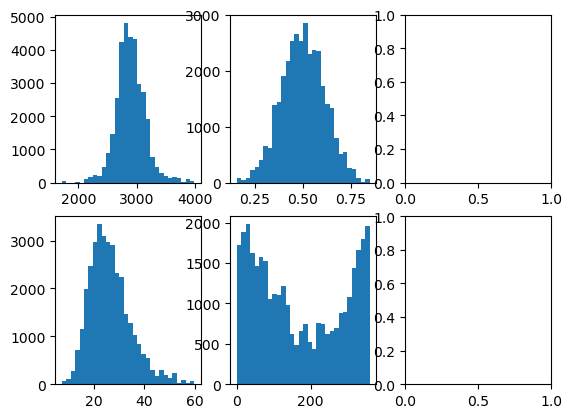

In [6]:
#from astropy.visualization import hist
fig,axes = plt.subplots(2,3)

ax1 = axes[0,0]
ax1.hist(df_fin['Zmed'], bins = 30)

ax2 = axes[0,1]
ax2.hist(df_fin['HI'], bins = 30)

ax3 = axes[1,0]
ax3.hist(df_fin['Slope'], bins = 30)

ax3 = axes[1,1]
ax3.hist(df_fin['Aspect'], bins = 30)

(array([3390., 1695., 1695., 6780., 6780., 3390., 3390., 5085.,    0.,
        1695.]),
 array([108.23322296, 127.15396194, 146.07470093, 164.99543991,
        183.91617889, 202.83691788, 221.75765686, 240.67839584,
        259.59913483, 278.51987381, 297.44061279]),
 <BarContainer object of 10 artists>)

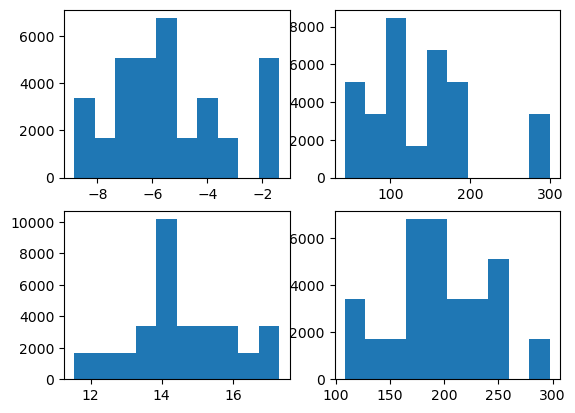

In [7]:
#from astropy.visualization import hist
fig,axes = plt.subplots(2,2)

ax1 = axes[0,0]
ax1.hist(df_fin['jan_temp'], bins = 10)

ax2 = axes[0,1]
ax2.hist(df_fin['jan_prcp'], bins = 10)

ax3 = axes[1,0]
ax3.hist(df_fin['jul_temp'], bins = 10)

ax4 = axes[1,1]
ax4.hist(df_fin['jul_prcp'], bins = 10)

In [8]:
df_fin['mass'].min()

1885265.699327938

(array([3.3765e+04, 8.6000e+01, 2.9000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 1.6000e+01]),
 array([1.88526570e+06, 1.15919521e+12, 2.31838853e+12, 3.47758186e+12,
        4.63677518e+12, 5.79596850e+12, 6.95516183e+12, 8.11435515e+12,
        9.27354847e+12, 1.04327418e+13, 1.15919351e+13]),
 <BarContainer object of 10 artists>)

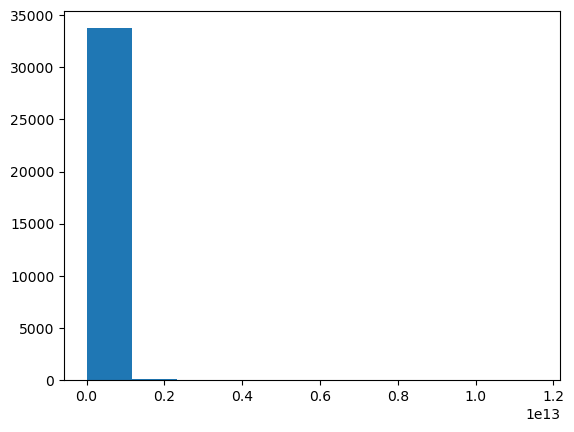

In [9]:
fig,axes = plt.subplots(1,1)

axes.hist(df_fin['mass'])

In [10]:
df_fin['mass'] = df_fin['mass'].apply(lambda x: np.log(x+1))

(array([2.0000e+00, 2.6000e+01, 3.3580e+03, 1.0493e+04, 9.4090e+03,
        6.4860e+03, 2.9120e+03, 9.0400e+02, 2.6500e+02, 4.5000e+01]),
 array([14.44957985, 16.01275494, 17.57593003, 19.13910511, 20.7022802 ,
        22.26545529, 23.82863038, 25.39180546, 26.95498055, 28.51815564,
        30.08133072]),
 <BarContainer object of 10 artists>)

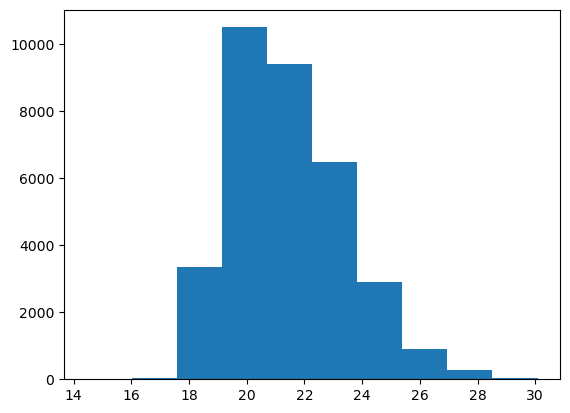

In [11]:
fig,axes = plt.subplots(1,1)

axes.hist(df_fin['mass'])

In [12]:
df_fin.tail()
df_fin.to_csv('final_scaled.csv', index = False)

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense, Dropout, Bidirectional, RNN
from sklearn.model_selection import train_test_split
import math
from tensorflow.keras.utils import plot_model
import pydot
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

from numpy.random import seed
import random as python_random


def reset_seeds():
    seed(417)
    tf.random.set_seed(417)
    python_random.seed(417)

2024-09-04 12:15:15.707175: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 12:15:25.546852: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
np.max(df_fin['mass'])

30.081330723910394

In [14]:
scaler = MinMaxScaler()
df_X = df_fin[['jul_temp','jul_prcp','jan_temp','jan_prcp','Zmed','Slope','Aspect','HI']]
df_X = scaler.fit_transform(df_X)

df_y = df_fin[['mass']]
df_y = scaler.fit_transform(df_y)

In [15]:
#df_X = df_X.to_numpy()
df_X = df_X.reshape(1695,20,8)#magic number...change

#df_y = df_y.to_numpy()
df_y = df_y.reshape(1695,20)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.25,random_state = 123)

In [16]:
model = tf.keras.Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True,input_shape=(20, 8), activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(64,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(32,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(16,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=8, return_sequences=True,activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=4, return_sequences=True,activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=2,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
model.add(Dropout(0.1))
model.add(Dense(1))

my_adam_optimizer = Adam(learning_rate=1e-6)
model.compile(optimizer=my_adam_optimizer, loss='mse', metrics = ['acc'])

2024-09-03 13:56:50.791907: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-09-03 13:56:50.791985: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: notch309
2024-09-03 13:56:50.791994: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: notch309
2024-09-03 13:56:50.792176: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.54.14
2024-09-03 13:56:50.792196: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.54.14
2024-09-03 13:56:50.792202: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 550.54.14
/uufs/chpc.utah.edu/common/home/u1459437/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not

In [17]:
history = model.fit(X_train, y_train,validation_data=(X_test,y_test),epochs =5)

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 182ms/step - acc: 4.0104e-05 - loss: 0.1656 - val_acc: 0.0000e+00 - val_loss: 0.1554
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - acc: 1.1772e-05 - loss: 0.1606 - val_acc: 0.0000e+00 - val_loss: 0.1460
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - acc: 3.0823e-05 - loss: 0.1488 - val_acc: 0.0000e+00 - val_loss: 0.1373
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - acc: 1.0686e-04 - loss: 0.1392 - val_acc: 0.0000e+00 - val_loss: 0.1292
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - acc: 4.2826e-05 - loss: 0.1298 - val_acc: 0.0000e+00 - val_loss: 0.1217


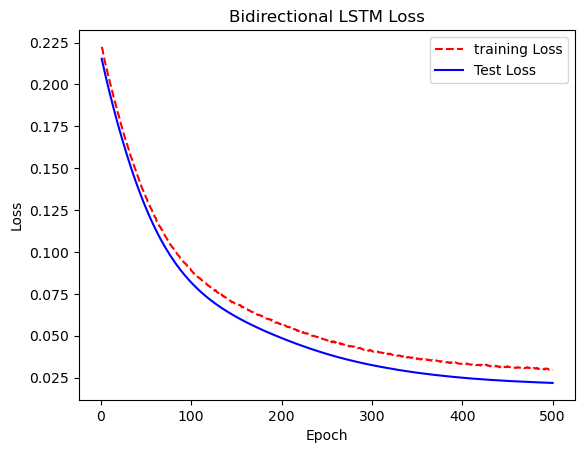

In [21]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Bidirectional LSTM Loss')
plt.show();

In [22]:
trainScore = model.evaluate(X_train, y_train, verbose=2)
#print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_test, y_test, verbose=2)
#print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

40/40 - 1s - 15ms/step - acc: 3.9339e-05 - loss: 0.0223
14/14 - 0s - 16ms/step - acc: 0.0000e+00 - loss: 0.0218


In [23]:
trainScore

[0.022327933460474014, 3.9339101931545883e-05]

In [24]:
testScore

[0.02180754579603672, 0.0]

In [25]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions-guessing i have to loop thru this for 3d?
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1,1)).reshape(trainPredict.shape)
testPredict = scaler.inverse_transform(testPredict.reshape(-1,1)).reshape(testPredict.shape).squeeze()

testY = scaler.inverse_transform(y_test)

testScore = (np.sqrt(mean_squared_error(testY, testPredict)))
print('Test Score: %.2f RMSE' % (testScore))

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test Score: 2.30 RMSE


In [26]:
loss_mape2 = tf.reduce_mean(tf.abs(tf.divide(tf.subtract(testPredict,testY),(testY+ 1e-10))))
loss_mape2*100

<tf.Tensor: shape=(), dtype=float32, numpy=8.29317>

### Random forest generic test

In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error

In [71]:
X_train.shape

(1271, 20, 8)

In [72]:
scaler = MinMaxScaler()
df_X = df_fin[['jul_temp','jul_prcp','jan_temp','jan_prcp','Zmed','Slope','Aspect','HI']]
df_X = scaler.fit_transform(df_X)

df_y = df_fin[['mass']]
df_y = scaler.fit_transform(df_y)

X_train2, X_test2, y_train2, y_test2 = train_test_split(df_X, df_y, test_size=0.25,random_state = 123)

In [73]:
params = {
    "n_estimators": 500,
    "random_state": 42,
    "oob_score":True,
    "max_depth":8
}

reg =RandomForestRegressor(**params)



reg.fit(X_train2, y_train2)

/uufs/chpc.utah.edu/common/home/u1459437/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=8, n_estimators=500, oob_score=True,
                      random_state=42)

In [75]:
y_pred2 = reg.predict(X_test2)

In [81]:
y_pred2 = scaler.inverse_transform(y_pred2.reshape(-1,1))
y_test = scaler.inverse_transform(y_test2.reshape(-1,1))

In [82]:
np.sqrt(mean_squared_error(y_test2, y_pred2, squared=False))

4.584653262381491

In [83]:
mean_absolute_error(y_test2, y_pred2)

20.98909534563793

### 5 Fold Cross Validation

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense, Dropout, Bidirectional, RNN
from sklearn.model_selection import train_test_split
import math
from tensorflow.keras.utils import plot_model
import pydot
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

from numpy.random import seed
import random as python_random


def reset_seeds():
    seed(417)
    tf.random.set_seed(417)
    python_random.seed(417)

2024-09-07 18:44:53.570006: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-07 18:44:55.280881: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-07 18:44:59.403102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df_fin = pd.read_csv('final_scaled.csv')
df_fin.head()

,RGI_ID,years,mass,jan_temp,jan_prcp,jul_temp,jul_prcp,Slope,Aspect,Zmed,HI
0,RGI60-11.00002,2000,25.235690,-7.131073,159.901688,11.542938,236.637115,18.6,49,2526,0.495399
1,RGI60-11.00002,2001,25.249843,-5.533630,79.804756,13.946198,160.340286,18.6,49,2526,0.495399
2,RGI60-11.00002,2002,25.227328,-5.909180,53.714611,14.390503,196.515427,18.6,49,2526,0.495399
3,RGI60-11.00002,2003,25.209608,-5.967377,114.225914,14.402863,174.810440,18.6,49,2526,0.495399
4,RGI60-11.00002,2004,25.221589,-6.445190,180.218323,13.262054,192.130508,18.6,49,2526,0.495399


In [4]:
def setup(df_fin,size):
    scaler = MinMaxScaler()
    df_X = df_fin[['jul_temp','jul_prcp','jan_temp','jan_prcp','Zmed','Slope','Aspect','HI']]
    df_X = scaler.fit_transform(df_X)

    df_y = df_fin[['mass']]
    df_y = scaler.fit_transform(df_y)
    
    #df_X = df_X.to_numpy()
    df_X = df_X.reshape(size,20,8)#magic number...change

    #df_y = df_y.to_numpy()
    df_y = df_y.reshape(size,20)

    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.25,random_state = 123)
    return X_train,y_train,X_test,y_test,scaler

In [5]:
def run_model(X_train,y_train,X_test,y_test,epochs):
    model = tf.keras.Sequential()
    model.add(Bidirectional(LSTM(128,return_sequences=True,input_shape=(20, 8), activation = 'tanh',recurrent_dropout=0.1)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(64,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(32,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(16,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units=8, return_sequences=True,activation = 'tanh',recurrent_dropout=0.1)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units=4, return_sequences=True,activation = 'tanh',recurrent_dropout=0.1)))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units=2,return_sequences=True, activation = 'tanh',recurrent_dropout=0.1)))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    my_adam_optimizer = Adam(learning_rate=1e-6)
    model.compile(optimizer=my_adam_optimizer, loss='mse', metrics = ['acc'])
    
    history = model.fit(X_train, y_train,validation_data=(X_test,y_test),epochs = epochs)
    return history,model

In [6]:
def get_predictions(X_train,y_train,X_test,y_test,model,scaler):
    # make predictions
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    # invert predictions-guessing i have to loop thru this for 3d?
    trainPredict = scaler.inverse_transform(trainPredict.reshape(-1,1)).reshape(trainPredict.shape)
    testPredict = scaler.inverse_transform(testPredict.reshape(-1,1)).reshape(testPredict.shape).squeeze()

    testY = scaler.inverse_transform(y_test)

    testScore = (np.sqrt(mean_squared_error(testY, testPredict)))
    print('Test Score: %.2f RMSE' % (testScore))
    
    loss_mape2 = tf.reduce_mean(tf.abs(tf.divide(tf.subtract(testPredict,testY),(testY+ 1e-10))))
    loss_mape2 = loss_mape2*100
    
    return testScore,loss_mape2

In [7]:
testScores = []
lossMapes = []
for i in range(0,5):
    X_train,y_train,X_test,y_test,scaler = setup(df_fin,1695)
    history,model = run_model(X_train,y_train,X_test,y_test,600)
    testScore,loss_mape2 = get_predictions(X_train,y_train,X_test,y_test,model,scaler)
    testScores.append(testScore)
    lossMapes.append(loss_mape2)
                                           

Epoch 1/600


2024-09-07 18:45:41.408471: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-09-07 18:45:41.408546: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: notch309
2024-09-07 18:45:41.408555: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: notch309
2024-09-07 18:45:41.408749: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.54.14
2024-09-07 18:45:41.408769: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.54.14
2024-09-07 18:45:41.408775: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 550.54.14
/uufs/chpc.utah.edu/common/home/u1459437/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not

40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 220ms/step - acc: 4.0104e-05 - loss: 0.2664 - val_acc: 0.0000e+00 - val_loss: 0.2496
Epoch 2/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - acc: 7.0765e-06 - loss: 0.2478 - val_acc: 0.0000e+00 - val_loss: 0.2355
Epoch 3/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - acc: 1.2591e-04 - loss: 0.2363 - val_acc: 0.0000e+00 - val_loss: 0.2217
Epoch 4/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - acc: 2.8962e-06 - loss: 0.2232 - val_acc: 0.0000e+00 - val_loss: 0.2082
Epoch 5/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - acc: 3.2940e-05 - loss: 0.2132 - val_acc: 0.0000e+00 - val_loss: 0.1949
Epoch 6/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 2.8817e-05 - loss: 0.1973 - val_acc: 0.0000e+00 - val_loss: 0.1821
Epoch 7/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - acc: 3.7564e-05 - loss: 0.1855 - val_acc: 0.0000e+00 - val_loss: 0.1697
Epoch 8/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - acc: 4.5758e-05 - loss: 0.1712 - val_acc: 0.0000e+00 - val_loss: 0

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - acc: 6.0444e-05 - loss: 0.0362 - val_acc: 0.0000e+00 - val_loss: 0.0218
Epoch 102/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - acc: 3.0823e-05 - loss: 0.0337 - val_acc: 0.0000e+00 - val_loss: 0.0217
Epoch 103/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 1.6402e-04 - loss: 0.0330 - val_acc: 0.0000e+00 - val_loss: 0.0217
Epoch 104/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - acc: 5.6209e-05 - loss: 0.0329 - val_acc: 0.0000e+00 - val_loss: 0.0217
Epoch 105/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - acc: 7.0765e-06 - loss: 0.0318 - val_acc: 0.0000e+00 - val_loss: 0.0216
Epoch 106/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - acc: 4.0104e-05 - loss: 0.0338 - val_acc: 0.0000e+00 - val_loss: 0.0216
Epoch 107/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - acc: 4.8934e-05 - loss: 0.0329 - val_acc: 0.0000e+00 - val_loss: 0.0216
Epoch 108/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - acc: 3.7564e-05 - loss: 0.0329 - val_acc: 0.0000e+

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - acc: 1.7129e-05 - loss: 0.0280 - val_acc: 0.0000e+00 - val_loss: 0.0181
Epoch 202/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - acc: 1.8595e-05 - loss: 0.0270 - val_acc: 0.0000e+00 - val_loss: 0.0181
Epoch 203/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - acc: 5.2398e-05 - loss: 0.0292 - val_acc: 0.0000e+00 - val_loss: 0.0180
Epoch 204/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - acc: 2.5097e-05 - loss: 0.0281 - val_acc: 0.0000e+00 - val_loss: 0.0180
Epoch 205/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - acc: 5.6209e-05 - loss: 0.0274 - val_acc: 0.0000e+00 - val_loss: 0.0180
Epoch 206/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - acc: 4.2826e-05 - loss: 0.0286 - val_acc: 0.0000e+00 - val_loss: 0.0180
Epoch 207/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - acc: 2.8817e-05 - loss: 0.0283 - val_acc: 0.0000e+00 - val_loss: 0.0180
Epoch 208/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 2.0120e-05 - loss: 0.0273 - val_acc: 0.0000e+0

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - acc: 4.0104e-05 - loss: 0.0263 - val_acc: 0.0000e+00 - val_loss: 0.0165
Epoch 302/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - acc: 3.2940e-05 - loss: 0.0252 - val_acc: 0.0000e+00 - val_loss: 0.0164
Epoch 303/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - acc: 1.2591e-04 - loss: 0.0264 - val_acc: 0.0000e+00 - val_loss: 0.0164
Epoch 304/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - acc: 7.0652e-05 - loss: 0.0255 - val_acc: 0.0000e+00 - val_loss: 0.0164
Epoch 305/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - acc: 2.6911e-05 - loss: 0.0249 - val_acc: 0.0000e+00 - val_loss: 0.0164
Epoch 306/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - acc: 2.5097e-05 - loss: 0.0259 - val_acc: 0.0000e+00 - val_loss: 0.0164
Epoch 307/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 1.7129e-05 - loss: 0.0261 - val_acc: 0.0000e+00 - val_loss: 0.0164
Epoch 308/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 6.5207e-05 - loss: 0.0246 - val_acc: 0.0000e+00

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - acc: 1.0543e-05 - loss: 0.0236 - val_acc: 0.0000e+00 - val_loss: 0.0156
Epoch 402/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - acc: 3.2940e-05 - loss: 0.0261 - val_acc: 0.0000e+00 - val_loss: 0.0156
Epoch 403/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - acc: 1.0686e-04 - loss: 0.0251 - val_acc: 0.0000e+00 - val_loss: 0.0156
Epoch 404/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - acc: 7.7003e-05 - loss: 0.0243 - val_acc: 0.0000e+00 - val_loss: 0.0156
Epoch 405/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - acc: 1.1772e-05 - loss: 0.0245 - val_acc: 0.0000e+00 - val_loss: 0.0156
Epoch 406/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - acc: 4.8934e-05 - loss: 0.0260 - val_acc: 0.0000e+00 - val_loss: 0.0156
Epoch 407/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - acc: 1.6402e-04 - loss: 0.0240 - val_acc: 0.0000e+00 - val_loss: 0.0156
Epoch 408/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - acc: 1.6402e-04 - loss: 0.0248 - val_acc: 0.0000e+0

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - acc: 2.6911e-05 - loss: 0.0242 - val_acc: 0.0000e+00 - val_loss: 0.0150
Epoch 502/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - acc: 4.5758e-05 - loss: 0.0240 - val_acc: 0.0000e+00 - val_loss: 0.0150
Epoch 503/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - acc: 1.4357e-05 - loss: 0.0232 - val_acc: 0.0000e+00 - val_loss: 0.0150
Epoch 504/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - acc: 1.0543e-05 - loss: 0.0238 - val_acc: 0.0000e+00 - val_loss: 0.0150
Epoch 505/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - acc: 9.0771e-05 - loss: 0.0227 - val_acc: 0.0000e+00 - val_loss: 0.0150
Epoch 506/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - acc: 6.0444e-05 - loss: 0.0233 - val_acc: 0.0000e+00 - val_loss: 0.0150
Epoch 507/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - acc: 4.8934e-05 - loss: 0.0233 - val_acc: 0.0000e+00 - val_loss: 0.0150
Epoch 508/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - acc: 7.0765e-06 - loss: 0.0232 - val_acc: 0.0000e+00

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Test Score: 1.88 RMSE
Epoch 1/600


/uufs/chpc.utah.edu/common/home/u1459437/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 193ms/step - acc: 1.1772e-05 - loss: 0.2095 - val_acc: 0.0000e+00 - val_loss: 0.1975
Epoch 2/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - acc: 1.9190e-06 - loss: 0.2057 - val_acc: 0.0000e+00 - val_loss: 0.1917
Epoch 3/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 3.8990e-06 - loss: 0.1993 - val_acc: 0.0000e+00 - val_loss: 0.1862
Epoch 4/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 3.2940e-05 - loss: 0.1885 - val_acc: 0.0000e+00 - val_loss: 0.1807
Epoch 5/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - acc: 1.0686e-04 - loss: 0.1780 - val_acc: 0.0000e+00 - val_loss: 0.1755
Epoch 6/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - acc: 1.8595e-05 - loss: 0.1801 - val_acc: 0.0000e+00 - val_loss: 0.1703
Epoch 7/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - acc: 4.8934e-05 - loss: 0.1751 - val_acc: 0.0000e+00 - val_loss: 0.1654
Epoch 8/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - acc: 8.4625e-05 - loss: 0.1678 - val_acc: 0.0000e+00 - val_loss: 0

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - acc: 1.7129e-05 - loss: 0.0459 - val_acc: 0.0000e+00 - val_loss: 0.0368
Epoch 102/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 1.0543e-05 - loss: 0.0489 - val_acc: 0.0000e+00 - val_loss: 0.0364
Epoch 103/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - acc: 1.3043e-05 - loss: 0.0462 - val_acc: 0.0000e+00 - val_loss: 0.0361
Epoch 104/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - acc: 6.5207e-05 - loss: 0.0450 - val_acc: 0.0000e+00 - val_loss: 0.0358
Epoch 105/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - acc: 1.4357e-05 - loss: 0.0434 - val_acc: 0.0000e+00 - val_loss: 0.0354
Epoch 106/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - acc: 2.8817e-05 - loss: 0.0447 - val_acc: 0.0000e+00 - val_loss: 0.0351
Epoch 107/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - acc: 1.5718e-05 - loss: 0.0436 - val_acc: 0.0000e+00 - val_loss: 0.0348
Epoch 108/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - acc: 9.3522e-06 - loss: 0.0450 - val_acc: 0.0000e+00 

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 7.0765e-06 - loss: 0.0364 - val_acc: 0.0000e+00 - val_loss: 0.0271
Epoch 202/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - acc: 2.6911e-05 - loss: 0.0368 - val_acc: 0.0000e+00 - val_loss: 0.0271
Epoch 203/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - acc: 1.1772e-05 - loss: 0.0373 - val_acc: 0.0000e+00 - val_loss: 0.0270
Epoch 204/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - acc: 9.3522e-06 - loss: 0.0373 - val_acc: 0.0000e+00 - val_loss: 0.0270
Epoch 205/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - acc: 1.6402e-04 - loss: 0.0368 - val_acc: 0.0000e+00 - val_loss: 0.0270
Epoch 206/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - acc: 1.0543e-05 - loss: 0.0358 - val_acc: 0.0000e+00 - val_loss: 0.0270
Epoch 207/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - acc: 5.6209e-05 - loss: 0.0367 - val_acc: 0.0000e+00 - val_loss: 0.0269
Epoch 208/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 6.0444e-05 - loss: 0.0376 - val_acc: 0.0000e+00 -

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - acc: 2.8817e-05 - loss: 0.0337 - val_acc: 0.0000e+00 - val_loss: 0.0244
Epoch 302/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - acc: 2.6911e-05 - loss: 0.0355 - val_acc: 0.0000e+00 - val_loss: 0.0244
Epoch 303/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - acc: 1.0543e-05 - loss: 0.0340 - val_acc: 0.0000e+00 - val_loss: 0.0243
Epoch 304/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - acc: 2.8962e-06 - loss: 0.0326 - val_acc: 0.0000e+00 - val_loss: 0.0243
Epoch 305/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - acc: 9.4153e-05 - loss: 0.0334 - val_acc: 0.0000e+00 - val_loss: 0.0243
Epoch 306/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - acc: 5.6209e-05 - loss: 0.0322 - val_acc: 0.0000e+00 - val_loss: 0.0243
Epoch 307/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - acc: 5.2398e-05 - loss: 0.0340 - val_acc: 0.0000e+00 - val_loss: 0.0242
Epoch 308/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - acc: 9.3522e-06 - loss: 0.0331 - val_acc: 0.0000e+00

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - acc: 2.8817e-05 - loss: 0.0312 - val_acc: 0.0000e+00 - val_loss: 0.0211
Epoch 402/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - acc: 1.3043e-05 - loss: 0.0295 - val_acc: 0.0000e+00 - val_loss: 0.0211
Epoch 403/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - acc: 3.5182e-05 - loss: 0.0301 - val_acc: 0.0000e+00 - val_loss: 0.0210
Epoch 404/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - acc: 1.7129e-05 - loss: 0.0318 - val_acc: 0.0000e+00 - val_loss: 0.0210
Epoch 405/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - acc: 7.0652e-05 - loss: 0.0313 - val_acc: 0.0000e+00 - val_loss: 0.0210
Epoch 406/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - acc: 1.1772e-05 - loss: 0.0299 - val_acc: 0.0000e+00 - val_loss: 0.0210
Epoch 407/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - acc: 1.7129e-05 - loss: 0.0299 - val_acc: 0.0000e+00 - val_loss: 0.0209
Epoch 408/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - acc: 4.8934e-05 - loss: 0.0308 - val_acc: 0.0000e+0

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - acc: 3.0823e-05 - loss: 0.0286 - val_acc: 0.0000e+00 - val_loss: 0.0191
Epoch 502/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - acc: 7.7003e-05 - loss: 0.0283 - val_acc: 0.0000e+00 - val_loss: 0.0191
Epoch 503/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - acc: 2.5097e-05 - loss: 0.0285 - val_acc: 0.0000e+00 - val_loss: 0.0191
Epoch 504/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - acc: 1.3043e-05 - loss: 0.0276 - val_acc: 0.0000e+00 - val_loss: 0.0191
Epoch 505/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - acc: 1.7129e-05 - loss: 0.0274 - val_acc: 0.0000e+00 - val_loss: 0.0191
Epoch 506/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - acc: 1.8595e-05 - loss: 0.0299 - val_acc: 0.0000e+00 - val_loss: 0.0190
Epoch 507/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - acc: 1.1772e-05 - loss: 0.0284 - val_acc: 0.0000e+00 - val_loss: 0.0190
Epoch 508/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - acc: 2.0120e-05 - loss: 0.0277 - val_acc: 0.0000e

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Test Score: 2.09 RMSE
Epoch 1/600


/uufs/chpc.utah.edu/common/home/u1459437/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 188ms/step - acc: 4.2826e-05 - loss: 0.2502 - val_acc: 0.0000e+00 - val_loss: 0.2334
Epoch 2/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - acc: 4.2826e-05 - loss: 0.2349 - val_acc: 0.0000e+00 - val_loss: 0.2192
Epoch 3/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - acc: 1.1772e-05 - loss: 0.2222 - val_acc: 0.0000e+00 - val_loss: 0.2058
Epoch 4/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - acc: 4.8934e-05 - loss: 0.2054 - val_acc: 0.0000e+00 - val_loss: 0.1932
Epoch 5/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - acc: 2.6911e-05 - loss: 0.1960 - val_acc: 0.0000e+00 - val_loss: 0.1812
Epoch 6/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - acc: 4.2826e-05 - loss: 0.1842 - val_acc: 0.0000e+00 - val_loss: 0.1700
Epoch 7/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - acc: 2.0120e-05 - loss: 0.1674 - val_acc: 0.0000e+00 - val_loss: 0.1594
Epoch 8/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - acc: 1.0543e-05 - loss: 0.1662 - val_acc: 0.0000e+00 - val_loss

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - acc: 3.2940e-05 - loss: 0.0296 - val_acc: 0.0000e+00 - val_loss: 0.0218
Epoch 102/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - acc: 5.2398e-05 - loss: 0.0296 - val_acc: 0.0000e+00 - val_loss: 0.0218
Epoch 103/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - acc: 2.1708e-05 - loss: 0.0290 - val_acc: 0.0000e+00 - val_loss: 0.0217
Epoch 104/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - acc: 2.5097e-05 - loss: 0.0297 - val_acc: 0.0000e+00 - val_loss: 0.0217
Epoch 105/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - acc: 1.6402e-04 - loss: 0.0313 - val_acc: 0.0000e+00 - val_loss: 0.0216
Epoch 106/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - acc: 1.7129e-05 - loss: 0.0286 - val_acc: 0.0000e+00 - val_loss: 0.0215
Epoch 107/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - acc: 1.9190e-06 - loss: 0.0280 - val_acc: 0.0000e+00 - val_loss: 0.0215
Epoch 108/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - acc: 3.2940e-05 - loss: 0.0289 - val_acc: 0.0000e+00

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - acc: 1.0686e-04 - loss: 0.0266 - val_acc: 0.0000e+00 - val_loss: 0.0166
Epoch 202/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - acc: 2.8962e-06 - loss: 0.0252 - val_acc: 0.0000e+00 - val_loss: 0.0166
Epoch 203/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - acc: 4.2826e-05 - loss: 0.0251 - val_acc: 0.0000e+00 - val_loss: 0.0166
Epoch 204/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - acc: 7.0765e-06 - loss: 0.0255 - val_acc: 0.0000e+00 - val_loss: 0.0165
Epoch 205/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - acc: 1.0686e-04 - loss: 0.0254 - val_acc: 0.0000e+00 - val_loss: 0.0165
Epoch 206/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - acc: 3.8990e-06 - loss: 0.0247 - val_acc: 0.0000e+00 - val_loss: 0.0165
Epoch 207/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - acc: 2.3364e-05 - loss: 0.0252 - val_acc: 0.0000e+00 - val_loss: 0.0165
Epoch 208/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - acc: 1.8595e-05 - loss: 0.0241 - val_acc: 0.0000e+

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - acc: 1.3043e-05 - loss: 0.0242 - val_acc: 0.0000e+00 - val_loss: 0.0150
Epoch 302/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - acc: 6.0444e-05 - loss: 0.0232 - val_acc: 0.0000e+00 - val_loss: 0.0150
Epoch 303/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - acc: 5.2398e-05 - loss: 0.0231 - val_acc: 0.0000e+00 - val_loss: 0.0150
Epoch 304/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - acc: 1.1772e-05 - loss: 0.0242 - val_acc: 0.0000e+00 - val_loss: 0.0150
Epoch 305/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - acc: 4.5758e-05 - loss: 0.0248 - val_acc: 0.0000e+00 - val_loss: 0.0150
Epoch 306/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - acc: 7.0652e-05 - loss: 0.0222 - val_acc: 0.0000e+00 - val_loss: 0.0150
Epoch 307/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - acc: 2.1708e-05 - loss: 0.0235 - val_acc: 0.0000e+00 - val_loss: 0.0150
Epoch 308/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - acc: 1.8595e-05 - loss: 0.0247 - val_acc: 0.0000e+0

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - acc: 1.0543e-05 - loss: 0.0231 - val_acc: 0.0000e+00 - val_loss: 0.0144
Epoch 402/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - acc: 1.5261e-04 - loss: 0.0223 - val_acc: 0.0000e+00 - val_loss: 0.0144
Epoch 403/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - acc: 2.7264e-05 - loss: 0.0223 - val_acc: 0.0000e+00 - val_loss: 0.0144
Epoch 404/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - acc: 2.1708e-05 - loss: 0.0220 - val_acc: 0.0000e+00 - val_loss: 0.0144
Epoch 405/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - acc: 6.5207e-05 - loss: 0.0234 - val_acc: 0.0000e+00 - val_loss: 0.0144
Epoch 406/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - acc: 3.0823e-05 - loss: 0.0224 - val_acc: 0.0000e+00 - val_loss: 0.0144
Epoch 407/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - acc: 6.4343e-05 - loss: 0.0224 - val_acc: 0.0000e+00 - val_loss: 0.0144
Epoch 408/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - acc: 1.0686e-04 - loss: 0.0227 - val_acc: 0.0000e+0

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - acc: 1.3043e-05 - loss: 0.0224 - val_acc: 0.0000e+00 - val_loss: 0.0141
Epoch 502/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - acc: 2.1708e-05 - loss: 0.0214 - val_acc: 0.0000e+00 - val_loss: 0.0140
Epoch 503/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - acc: 1.7129e-05 - loss: 0.0219 - val_acc: 0.0000e+00 - val_loss: 0.0140
Epoch 504/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - acc: 2.5097e-05 - loss: 0.0208 - val_acc: 0.0000e+00 - val_loss: 0.0140
Epoch 505/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - acc: 3.3480e-05 - loss: 0.0227 - val_acc: 0.0000e+00 - val_loss: 0.0140
Epoch 506/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - acc: 6.5207e-05 - loss: 0.0227 - val_acc: 0.0000e+00 - val_loss: 0.0140
Epoch 507/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - acc: 2.8817e-05 - loss: 0.0226 - val_acc: 0.0000e+00 - val_loss: 0.0140
Epoch 508/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - acc: 2.0120e-05 - loss: 0.0219 - val_acc: 0.0000e+00 

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Test Score: 1.83 RMSE
Epoch 1/600


/uufs/chpc.utah.edu/common/home/u1459437/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 171ms/step - acc: 2.8817e-05 - loss: 0.2040 - val_acc: 0.0000e+00 - val_loss: 0.1944
Epoch 2/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 2.6911e-05 - loss: 0.1996 - val_acc: 0.0000e+00 - val_loss: 0.1921
Epoch 3/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 4.9290e-06 - loss: 0.1951 - val_acc: 0.0000e+00 - val_loss: 0.1897
Epoch 4/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 5.6209e-05 - loss: 0.1969 - val_acc: 0.0000e+00 - val_loss: 0.1873
Epoch 5/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 3.7564e-05 - loss: 0.1957 - val_acc: 0.0000e+00 - val_loss: 0.1849
Epoch 6/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 2.1708e-05 - loss: 0.1904 - val_acc: 0.0000e+00 - val_loss: 0.1825
Epoch 7/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 1.4357e-05 - loss: 0.1903 - val_acc: 0.0000e+00 - val_loss: 0.1800
Epoch 8/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 4.2826e-05 - loss: 0.1838 - val_acc: 0.0000e+00 - val_loss: 0.

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 7.0765e-06 - loss: 0.0525 - val_acc: 0.0000e+00 - val_loss: 0.0433
Epoch 102/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 9.4153e-05 - loss: 0.0524 - val_acc: 0.0000e+00 - val_loss: 0.0430
Epoch 103/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 3.5182e-05 - loss: 0.0520 - val_acc: 0.0000e+00 - val_loss: 0.0427
Epoch 104/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 8.4625e-05 - loss: 0.0524 - val_acc: 0.0000e+00 - val_loss: 0.0424
Epoch 105/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 2.6911e-05 - loss: 0.0527 - val_acc: 0.0000e+00 - val_loss: 0.0421
Epoch 106/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - acc: 7.0765e-06 - loss: 0.0515 - val_acc: 0.0000e+00 - val_loss: 0.0418
Epoch 107/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - acc: 1.0543e-05 - loss: 0.0518 - val_acc: 0.0000e+00 - val_loss: 0.0415
Epoch 108/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 2.8817e-05 - loss: 0.0529 - val_acc: 0.0000e+00 

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 1.8595e-05 - loss: 0.0380 - val_acc: 0.0000e+00 - val_loss: 0.0281
Epoch 202/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 2.8817e-05 - loss: 0.0383 - val_acc: 0.0000e+00 - val_loss: 0.0281
Epoch 203/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 1.0686e-04 - loss: 0.0365 - val_acc: 0.0000e+00 - val_loss: 0.0280
Epoch 204/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 9.3522e-06 - loss: 0.0368 - val_acc: 0.0000e+00 - val_loss: 0.0279
Epoch 205/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 3.5182e-05 - loss: 0.0359 - val_acc: 0.0000e+00 - val_loss: 0.0278
Epoch 206/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - acc: 5.6209e-05 - loss: 0.0377 - val_acc: 0.0000e+00 - val_loss: 0.0278
Epoch 207/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - acc: 2.5097e-05 - loss: 0.0370 - val_acc: 0.0000e+00 - val_loss: 0.0277
Epoch 208/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - acc: 1.0686e-04 - loss: 0.0374 - val_acc: 0.0000e+00 

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 4.2826e-05 - loss: 0.0315 - val_acc: 0.0000e+00 - val_loss: 0.0237
Epoch 302/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 9.4153e-05 - loss: 0.0339 - val_acc: 0.0000e+00 - val_loss: 0.0237
Epoch 303/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - acc: 7.0652e-05 - loss: 0.0320 - val_acc: 0.0000e+00 - val_loss: 0.0237
Epoch 304/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 8.4625e-05 - loss: 0.0322 - val_acc: 0.0000e+00 - val_loss: 0.0237
Epoch 305/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 9.3522e-06 - loss: 0.0330 - val_acc: 0.0000e+00 - val_loss: 0.0236
Epoch 306/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 2.1708e-05 - loss: 0.0326 - val_acc: 0.0000e+00 - val_loss: 0.0236
Epoch 307/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - acc: 6.5207e-05 - loss: 0.0325 - val_acc: 0.0000e+00 - val_loss: 0.0236
Epoch 308/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - acc: 2.1708e-05 - loss: 0.0328 - val_acc: 0.0000e+00 -

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - acc: 5.9876e-06 - loss: 0.0282 - val_acc: 0.0000e+00 - val_loss: 0.0212
Epoch 402/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - acc: 7.0765e-06 - loss: 0.0290 - val_acc: 0.0000e+00 - val_loss: 0.0212
Epoch 403/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - acc: 5.9876e-06 - loss: 0.0298 - val_acc: 0.0000e+00 - val_loss: 0.0212
Epoch 404/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - acc: 7.0652e-05 - loss: 0.0287 - val_acc: 0.0000e+00 - val_loss: 0.0212
Epoch 405/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - acc: 2.6911e-05 - loss: 0.0308 - val_acc: 0.0000e+00 - val_loss: 0.0211
Epoch 406/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - acc: 2.5097e-05 - loss: 0.0296 - val_acc: 0.0000e+00 - val_loss: 0.0211
Epoch 407/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - acc: 1.3043e-05 - loss: 0.0291 - val_acc: 0.0000e+00 - val_loss: 0.0211
Epoch 408/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - acc: 1.0686e-04 - loss: 0.0300 - val_acc: 0.0000e+

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 5.6209e-05 - loss: 0.0280 - val_acc: 0.0000e+00 - val_loss: 0.0191
Epoch 502/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 2.0120e-05 - loss: 0.0275 - val_acc: 0.0000e+00 - val_loss: 0.0191
Epoch 503/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 1.7129e-05 - loss: 0.0275 - val_acc: 0.0000e+00 - val_loss: 0.0190
Epoch 504/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 3.2940e-05 - loss: 0.0276 - val_acc: 0.0000e+00 - val_loss: 0.0190
Epoch 505/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 2.1708e-05 - loss: 0.0282 - val_acc: 0.0000e+00 - val_loss: 0.0190
Epoch 506/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 1.6402e-04 - loss: 0.0277 - val_acc: 0.0000e+00 - val_loss: 0.0190
Epoch 507/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 4.2826e-05 - loss: 0.0268 - val_acc: 0.0000e+00 - val_loss: 0.0190
Epoch 508/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 2.5097e-05 - loss: 0.0269 - val_acc: 0.0000e+00 -

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Test Score: 2.09 RMSE
Epoch 1/600


/uufs/chpc.utah.edu/common/home/u1459437/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - acc: 2.8962e-06 - loss: 0.2691 - val_acc: 0.0000e+00 - val_loss: 0.2609
Epoch 2/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 9.4153e-05 - loss: 0.2650 - val_acc: 0.0000e+00 - val_loss: 0.2526
Epoch 3/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 4.0104e-05 - loss: 0.2590 - val_acc: 0.0000e+00 - val_loss: 0.2445
Epoch 4/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 6.5207e-05 - loss: 0.2536 - val_acc: 0.0000e+00 - val_loss: 0.2366
Epoch 5/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 7.0765e-06 - loss: 0.2422 - val_acc: 0.0000e+00 - val_loss: 0.2289
Epoch 6/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 2.6911e-05 - loss: 0.2357 - val_acc: 0.0000e+00 - val_loss: 0.2214
Epoch 7/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - acc: 1.6402e-04 - loss: 0.2251 - val_acc: 0.0000e+00 - val_loss: 0.2140
Epoch 8/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - acc: 1.0543e-05 - loss: 0.2174 - val_acc: 0.0000e+00 - val_loss: 0.

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - acc: 2.8817e-05 - loss: 0.0427 - val_acc: 0.0000e+00 - val_loss: 0.0299
Epoch 102/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 3.8990e-06 - loss: 0.0407 - val_acc: 0.0000e+00 - val_loss: 0.0297
Epoch 103/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 5.6209e-05 - loss: 0.0413 - val_acc: 0.0000e+00 - val_loss: 0.0295
Epoch 104/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - acc: 5.2398e-05 - loss: 0.0413 - val_acc: 0.0000e+00 - val_loss: 0.0294
Epoch 105/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 1.8595e-05 - loss: 0.0399 - val_acc: 0.0000e+00 - val_loss: 0.0292
Epoch 106/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 1.1772e-05 - loss: 0.0418 - val_acc: 0.0000e+00 - val_loss: 0.0290
Epoch 107/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - acc: 1.3043e-05 - loss: 0.0413 - val_acc: 0.0000e+00 - val_loss: 0.0289
Epoch 108/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - acc: 3.8990e-06 - loss: 0.0400 - val_acc: 0.0000e+00 

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - acc: 1.6402e-04 - loss: 0.0358 - val_acc: 0.0000e+00 - val_loss: 0.0230
Epoch 202/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - acc: 1.9190e-06 - loss: 0.0362 - val_acc: 0.0000e+00 - val_loss: 0.0230
Epoch 203/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - acc: 5.2398e-05 - loss: 0.0365 - val_acc: 0.0000e+00 - val_loss: 0.0230
Epoch 204/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - acc: 2.6911e-05 - loss: 0.0350 - val_acc: 0.0000e+00 - val_loss: 0.0230
Epoch 205/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - acc: 4.9290e-06 - loss: 0.0352 - val_acc: 0.0000e+00 - val_loss: 0.0229
Epoch 206/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - acc: 2.3364e-05 - loss: 0.0366 - val_acc: 0.0000e+00 - val_loss: 0.0229
Epoch 207/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - acc: 2.0120e-05 - loss: 0.0341 - val_acc: 0.0000e+00 - val_loss: 0.0229
Epoch 208/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - acc: 6.0444e-05 - loss: 0.0346 - val_acc: 0.0000e+00

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - acc: 4.2826e-05 - loss: 0.0313 - val_acc: 0.0000e+00 - val_loss: 0.0212
Epoch 302/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 3.7564e-05 - loss: 0.0323 - val_acc: 0.0000e+00 - val_loss: 0.0212
Epoch 303/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - acc: 1.0686e-04 - loss: 0.0319 - val_acc: 0.0000e+00 - val_loss: 0.0212
Epoch 304/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 8.4625e-05 - loss: 0.0337 - val_acc: 0.0000e+00 - val_loss: 0.0212
Epoch 305/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 1.2591e-04 - loss: 0.0316 - val_acc: 0.0000e+00 - val_loss: 0.0211
Epoch 306/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 5.9876e-06 - loss: 0.0309 - val_acc: 0.0000e+00 - val_loss: 0.0211
Epoch 307/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - acc: 3.8990e-06 - loss: 0.0327 - val_acc: 0.0000e+00 - val_loss: 0.0211
Epoch 308/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - acc: 5.2398e-05 - loss: 0.0315 - val_acc: 0.0000e+00 

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - acc: 1.4357e-05 - loss: 0.0306 - val_acc: 0.0000e+00 - val_loss: 0.0194
Epoch 402/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - acc: 3.8990e-06 - loss: 0.0295 - val_acc: 0.0000e+00 - val_loss: 0.0194
Epoch 403/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - acc: 8.1974e-06 - loss: 0.0295 - val_acc: 0.0000e+00 - val_loss: 0.0193
Epoch 404/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - acc: 1.8595e-05 - loss: 0.0289 - val_acc: 0.0000e+00 - val_loss: 0.0193
Epoch 405/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - acc: 5.6209e-05 - loss: 0.0301 - val_acc: 0.0000e+00 - val_loss: 0.0193
Epoch 406/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 1.5718e-05 - loss: 0.0301 - val_acc: 0.0000e+00 - val_loss: 0.0193
Epoch 407/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 4.8934e-05 - loss: 0.0289 - val_acc: 0.0000e+00 - val_loss: 0.0193
Epoch 408/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - acc: 4.5758e-05 - loss: 0.0290 - val_acc: 0.0000e+00 

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - acc: 3.4805e-05 - loss: 0.0284 - val_acc: 0.0000e+00 - val_loss: 0.0175
Epoch 502/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - acc: 1.0543e-05 - loss: 0.0282 - val_acc: 0.0000e+00 - val_loss: 0.0175
Epoch 503/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - acc: 1.6402e-04 - loss: 0.0272 - val_acc: 0.0000e+00 - val_loss: 0.0175
Epoch 504/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - acc: 1.2591e-04 - loss: 0.0275 - val_acc: 0.0000e+00 - val_loss: 0.0175
Epoch 505/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - acc: 5.9876e-06 - loss: 0.0279 - val_acc: 0.0000e+00 - val_loss: 0.0175
Epoch 506/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - acc: 1.4357e-05 - loss: 0.0293 - val_acc: 0.0000e+00 - val_loss: 0.0174
Epoch 507/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - acc: 6.2660e-05 - loss: 0.0282 - val_acc: 0.0000e+00 - val_loss: 0.0174
Epoch 508/600
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - acc: 4.5758e-05 - loss: 0.0282 - val_acc: 0.0000e+00

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Test Score: 2.01 RMSE


In [8]:
df_results = pd.DataFrame([testScores,lossMapes])
df_results.to_csv('crossvalidated_region11.csv', index = False)

In [8]:
results = pd.read_csv('crossvalidated_region11.csv')
results = results.transpose()
results.columns = ['RMSE','MAPE']
results.head()

,RMSE,MAPE
0,1.8838056336333913,"tf.Tensor(6.874898, shape=(), dtype=float32)"
1,2.085821316722872,"tf.Tensor(7.447841, shape=(), dtype=float32)"
2,1.8315761791632963,"tf.Tensor(6.734746, shape=(), dtype=float32)"
3,2.0919376675727857,"tf.Tensor(7.4872346, shape=(), dtype=float32)"
4,2.0135499187331414,"tf.Tensor(7.215843, shape=(), dtype=float32)"


In [9]:
results.to_csv('results_11alps.csv')